# Unsupervised NLP Analysis with Covid-19 Research Papers
## Author: Yonghao Li

Main questions to explore:
- What are the main areas of research for Covid-19 studies?
- How many research contributors are in this data of published papers?
- What are the risk factors associated with Covid-19?
- What are some actionable strategies or insights that we can devise from the analysis of this corpus of papers?

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Libraries
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

import csv
import random
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load word processing libraries
import re
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from wordcloud import WordCloud

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
time: 2.5 s (started: 2021-04-11 05:29:50 +00:00)


In [ ]:
# Display all content
# pd.set_option('display.max_colwidth', None)

time: 988 µs (started: 2021-04-11 05:29:53 +00:00)


# Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/metadata.csv', low_memory=False)
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


time: 15.5 s (started: 2021-04-11 05:29:53 +00:00)


In [ ]:
# load the meta data from the CSV file and extract out fields that will be useful to our application
df = df[['title','abstract','authors','publish_time']]
df = df.drop_duplicates(subset='abstract', keep='first')
df = df.dropna()
df['abstract'] = df['abstract'].str.lower()
df.head()

,title,abstract,authors,publish_time
0,Clinical features of culture-proven Mycoplasma...,objective: this retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in th...,"Crouch, Erika C",2000-08-25
3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22
4,Gene expression in epithelial cells in respons...,respiratory syncytial virus (rsv) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11


time: 2.59 s (started: 2021-04-11 05:30:08 +00:00)


In order to visualize the trend of published papers, we add a year column by extracting the year from the "publish time" column.

In [ ]:
# Add publish year feature
df.publish_time = pd.to_datetime(df['publish_time'],format='%Y-%m-%d', errors='coerce')
df['publish_year'] = pd.DatetimeIndex(df.publish_time).year
df.dtypes

title                   object
abstract                object
authors                 object
publish_time    datetime64[ns]
publish_year             int64
dtype: object

time: 117 ms (started: 2021-04-11 05:30:11 +00:00)


In [ ]:
df.shape

(321013, 5)

time: 4.53 ms (started: 2021-04-11 05:30:11 +00:00)


# Text Cleaning

Among the extracted features from the data, since the title of a scientific research paper is closely related to the abstract (or even just the same words from the abstract), we will look at the abstract only for preliminary analysis.

Using natural language toolkit (NLTK) stopwords, which include pronouns (such as 'i', 'we', 'she'), transitional words (such as 'the', 'and', 'if'), and other words that generally appear in scientific papers, we will eliminate some of the meaningless words in this context. This way, we can save space and extract meaningful words from text features for further analysis.

In [ ]:
# Using NLTK's list of stopwords
stopword_list = stopwords.words('english')
more_sw = ['doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author',
           'figure', 'table', 'rights', 'reserved', 'permission', 'use', 'used',
           'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.',
           'results', 'study', 'shown', 'based', 'found', 'could', 'observed',
           'cases', 'publisher', 'including', 'against', 'say', 'beyond', 'seem',
           'thereby', 'bottom', 'get', 'peer', 'review', 'permission', 'Elsevier',
           'PMC', 'CZI', 'may', 'also', 'due', 'however', 'within', 'del', 'las',
           'por', 'los', 'para', 'que', 'non', 'none', 'il', 'paper', 'undergo',
           'underwent', 'rt', 'les', 'number', 'numbers', 'propose', 'proposed',
           'one', 'two', 'three', 'assay', 'article', 'group', 'conclusion',
           'conclusions']
for sw in more_sw:
    stopword_list.append(sw)

time: 12.9 ms (started: 2021-04-11 06:02:19 +00:00)


Before analysis and modeling, we need to clean the text features to make sure that the remaining words are meaningful.

The pipeline for cleaning the paper abstracts is as follows:
- Remove HTML tags and attributes;
- Replace HTML character codes with ASCII equivalents;
- Remove URLs;
- Remove new-line characters, punctuations, and extra white spaces;
- Lemmatization of remaining words;
- Remove stopwords.

For this step, I chose not to remove all non-letter characters (such as '-' and numbers) because of the following reasons:
- 'Covid-19' is expected to be one of the most important words in this project, it might be best to keep it as is;
- There will be a lot of scientific names for viral strings, chemical compounds, or protein structures, such as 'sp-d' or 'et-1', which could be important to the problem that we are trying to analyze;
- Most of the compounded words might not make sense after stripping away the numbers.

In [ ]:
lemmatizer = WordNetLemmatizer()

# Create function for cleaning the tweets column
def clean_abstract(s):
    # Remove HTML tags and attributes from the string
    html_tags = re.compile('<.*?>')
    s = re.sub(html_tags, '', s)
    # Replace HTML character codes with ASCII equivalent
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')
    # Remove URLs
    s = re.sub(r'http\S+', '', s)
    # Remove new line and line breaks characters
    s = s.replace('b"', '').replace("b'", '').replace('\n', '').replace('\\n', '').replace('\\n\\n', '').replace('\t', '')
    # Remove punctuations
    s = re.sub('[^a-zA-z0-9\s-]', ' ', s)
    # Replace extra white spaces with one space
    s = re.sub(r'\s+', ' ', s)
    # Lemmatization
    s = lemmatizer.lemmatize(s)
    # Remove stop words
    text_tokens = word_tokenize(s)
    s = [word for word in text_tokens if not word in stopword_list]
    # Remove words with only 2 letters or less
    s = [i for i in s if len(i) > 2]
    return ' '.join(s)

time: 20 ms (started: 2021-04-11 05:30:11 +00:00)


In [ ]:
# Perform data cleaning on the "abstract" feature
df_cleaned = df.copy(deep=True)
df_cleaned['abstract'] = df_cleaned['abstract'].apply(clean_abstract)
df_cleaned.head()

,title,abstract,authors,publish_time,publish_year
0,Clinical features of culture-proven Mycoplasma...,objective retrospective chart describes epidem...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,2001
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases respiratory tract common...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15,2000
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d sp-d participates innate ...,"Crouch, Erika C",2000-08-25,2000
3,Role of endothelin-1 in lung disease,endothelin-1 et-1 amino acid peptide diverse b...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,2001
4,Gene expression in epithelial cells in respons...,respiratory syncytial virus rsv pneumonia viru...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11,2001


time: 8min 53s (started: 2021-04-11 06:02:24 +00:00)


# EDA and Data Visualizations

Out of the 321013 research papers left after removing duplicates and NAN values, it would be informative to look at the content and try to discover trends.

In [ ]:
# Function for counting unique strings in a column
def count_unique(df, col, delimiter):
    val_list = []
    for i in range(len(df)):
        val = df[col].iloc[i]
        split_val = val.split(delimiter)
        val_list.append(split_val)
    val_list = [item for sublist in val_list for item in sublist]
    num_unique = len(set(val_list))
    return num_unique

time: 7.37 ms (started: 2021-04-10 09:42:47 +00:00)


In [ ]:
# Count the number of unique authors in the data
count_unique(df_cleaned, 'authors', ';')

1153286

time: 5.74 s (started: 2021-04-10 09:42:47 +00:00)


From the above pipeline, we can see that there are around 1150000 different authors contributing to this large corpus of Covid-19 related research papers. This indicates that there are roughly 3 to 4 authors contributing to each research paper, which is common in the medical field.

The large number of researchers is reassuring because we can see how the world's brightest minds are working together to study and solve Covid-19.

In [ ]:
# Create a new column containing the most frequent word in each abstract
from collections import Counter

def most_frequent(words):
    l = word_tokenize(words)
    data = Counter(l)
    try:
        return max(l, key=data.get)
    except:
        return ''

df_cleaned['most_frequent_word'] = df_cleaned.abstract.apply(most_frequent)
df_cleaned.head()

,title,abstract,authors,publish_time,publish_year,most_frequent_word
0,Clinical features of culture-proven Mycoplasma...,objective retrospective chart describes epidem...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,2001,patients
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases respiratory tract common...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15,2000,evidence
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d sp-d participates innate ...,"Crouch, Erika C",2000-08-25,2000,sp-d
3,Role of endothelin-1 in lung disease,endothelin-1 et-1 amino acid peptide diverse b...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,2001,et-1
4,Gene expression in epithelial cells in respons...,respiratory syncytial virus rsv pneumonia viru...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11,2001,respiratory


time: 3min 58s (started: 2021-04-10 09:42:53 +00:00)


In [ ]:
# Show the most frequent words in all abstracts in this data
most_mentioned_words = df_cleaned.most_frequent_word.value_counts()[:15]
most_mentioned_words

covid-19       23640
patients       16610
sars-cov-2      6636
health          5189
disease         2684
pandemic        2678
virus           2284
care            2228
coronavirus     2013
respiratory     1860
model           1626
infection       1614
cells           1547
children        1545
social          1496
Name: most_frequent_word, dtype: int64

time: 119 ms (started: 2021-04-10 09:46:51 +00:00)


By extracting the most frequent keywords from the abstracts, the trend of the research topics are becoming clear. From the above list, we can see that the Covid-19 (otherwise known sars-cov-2 or coronavirus) virus is causing a pandemic that infects the respiratory system of patients in a cellular level.

Text(0.5, 1.0, 'Number of Published Papers by Year')

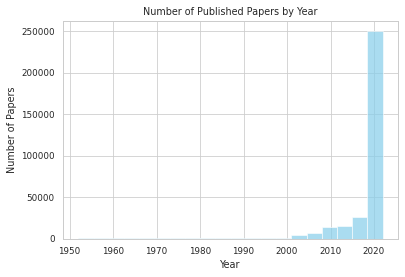

time: 608 ms (started: 2021-04-10 09:46:51 +00:00)


In [ ]:
# Number of published paper by year
sns.set_theme(style='whitegrid')
sns.set_context('paper')
plt.hist(list(df['publish_year']), bins=20, alpha=0.7, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Number of Published Papers by Year')

From the above bar plot we can see that the amount of paper published (related to Covid-19) skyrocketed around 2020 because of the pandemic outbreak.

Text(0.5, 1.0, 'Covid19 Research Paper Abstracts WordCloud')

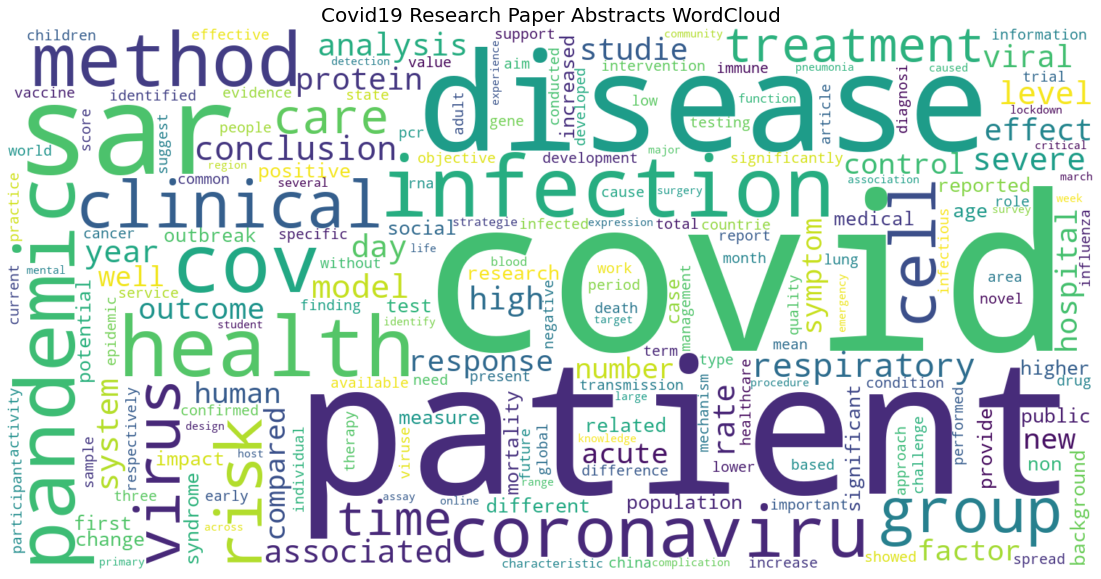

time: 1min 10s (started: 2021-04-10 17:51:36 +00:00)


In [ ]:
# Create word cloud for the abstracts
all_abstract = ' '.join(ab for ab in df_cleaned.abstract)
wordcloud_positive = WordCloud(width=1500, height=750, max_words=200, 
                               background_color='white', collocations=False).generate(all_abstract)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Covid19 Research Paper Abstracts WordCloud', fontsize=20)

From the word cloud generated above, we start to see some levels of research directions in the papers:
- Covid, cov, coronavirus, sar
- Virus, infection, cell, protein, treatment (virus study)
- Mortality, death (death rate study)
- Respiratory, age, lung, blood, protein, risk (risk factor study and impact analysis)

## Word Embeddings

Using word embedding can help retain some aspects of the original context and semantics. Word2Vec generates relatively small embedding vectors in which each dimension represents an informational aspect of the word.

Due to the large size of the corpus, min_count is set to 30000 in order to retain only words with a large amount of connections. This would make the similarity visualization easier to interpret.

In [ ]:
# Word2Vec
import gensim
from gensim.models import Word2Vec

# Tokenize words in each row
df_we = df_cleaned.abstract.apply(word_tokenize)
# Implement Word2Vec
df_we = Word2Vec(df_we, size=100, window=20, min_count=30000, workers=4)

time: 4min 40s (started: 2021-04-10 22:52:02 +00:00)


In [ ]:
# Show word similarities generated by word embeddings model
keywords = ['covid-19', 'infection', 'pandemic', 'lung', 'respiratory', 'treatment']
top_words_list = []

for i, word in enumerate(keywords):
    print(word + ":")
    top_words = df_we.most_similar(word)[:5]
    for idx, word in enumerate(top_words):
        print(str(idx+1) + ". " + word[0])
    print("")

covid-19:
1. 2020
2. confirmed
3. 2019
4. patients
5. severe

infection:
1. infected
2. viral
3. sars-cov-2
4. infections
5. virus

pandemic:
1. impact
2. global
3. world
4. 2020
5. social

lung:
1. cells
2. severe
3. cell
4. patients
5. respiratory

respiratory:
1. acute
2. severe
3. syndrome
4. coronavirus
5. viruses

treatment:
1. therapy
2. clinical
3. effective
4. patients
5. cancer

time: 25.7 ms (started: 2021-04-10 22:58:46 +00:00)


Looking at the similarities between words in the word embeddings model, we can definitely tell the severity of the situation. Covid-19 is a severe global pandemic that occurs since 2019 and continues into 2020. This viral infection affects that respiratory pathway of patients, espacially the lung, causing acute symptoms. The researchers are working hard on effective clinical treatments to fight this pandemic.

## TSNE Model and Plot with Word Embeddings

TSNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

It takes a group of high-dimensional (100 dimensions from Word2Vec) vocabulary vectors and compresses them down to 2-dimensional xy pairs with the help of PCA.

This is another way to visualize the most essential word similarities within the large text corpus.

In [ ]:
# Create TSNE model plot based on the word embeddings
def tsne_plot(model):
    
    labels = []
    tokens = []

    for word in df_we.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, init='pca', n_iter=2500, random_state=20)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=12)
    plt.title('TSNE Plot of Similar Words', fontsize=20)
    plt.gcf().set_tight_layout(True)
    plt.show()

time: 13.2 ms (started: 2021-04-10 22:59:00 +00:00)


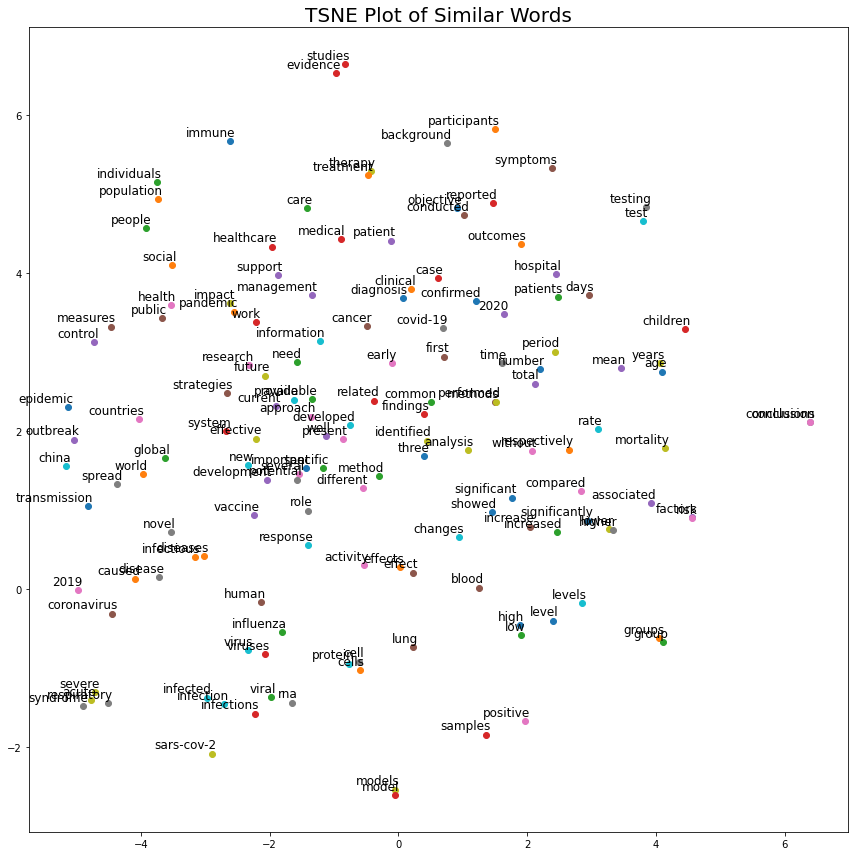

time: 3.07 s (started: 2021-04-10 22:59:02 +00:00)


In [ ]:
tsne_plot(df_we)

The TSNE plot shows the term "covid-19" in the center, surrounded by other relevant keywords. "Covid-19" is closely related to "diagnosis", "symptoms", and "patient". It is also related to "cancer", a high risk condition for being infected with covid-19. "Vaccine" is related to "strategies", "development", and "important". "Coronavirus" is related to "disease", "novel", "global", "outbreak", and "epidemic".

Similarities among these keywords make sense given the context of study.

# TFIDF Vectorization and Vectorizer Analysis

Using the term frequency–inverse document frequency (TF-IDF) vectorizer, we can get a sparse matrix with numerical representations of the importance of each word in the corpus. After that, we can visualize the top 20 words with the most importance numerical values.

In [ ]:
# Prepare the X feature
X = df_cleaned.abstract

time: 1.74 ms (started: 2021-04-11 06:11:18 +00:00)


In [ ]:
# TF-IDF with only alphabetical words
tfidf = TfidfVectorizer(max_features=1500, analyzer='word', token_pattern=r'(?u)\b[A-Za-z]+\b',
                        stop_words='english', ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)
X_tfidf.shape

(321013, 1500)

time: 35.6 s (started: 2021-04-11 06:11:18 +00:00)


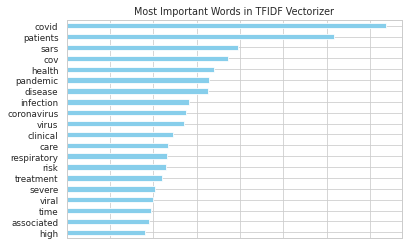

time: 388 ms (started: 2021-04-10 19:27:32 +00:00)


In [ ]:
# Show the 20 most frequent words
sns.set_theme(style='whitegrid')
sns.set_context('paper')
word_count = pd.DataFrame({'word': tfidf.get_feature_names(), 'count': np.asarray(X_tfidf.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh', legend=False, color='skyblue')
plt.title('Most Important Words in TFIDF Vectorizer')
ax1 = plt.axes()
ax1.axes.xaxis.set_ticklabels([])
y_axis = ax1.axes.get_yaxis()
y_axis.label.set_visible(False)
plt.show()

The top 20 words in the TF-IDF vectorizer are similar to what we would expect from the results of previous models.

# Random Sampling PCA and Mini-Batch KMeans Clustering

In order to maintain efficiency while using the elboa method to find the optimal k value for the k-means model, PCA is implemented before running the k-means algorithm. Within PCA dimensionality reduction, only 30000 rows of X feature are randomly sampled due to memory overload (more samples would lead to the crashing of PCA).

Mini-batch KMeans is better suited for processing large scale data (n_samples > 10k). It is an online implementation that does incremental updates of the centers positions using mini-batches.

In [ ]:
# Sampling and PCA
X_pca = X.sample(30000, random_state=1)
X_pca = tfidf.transform(X_pca)
pca = PCA(n_components=0.95, random_state=1)
X_pca = pca.fit_transform(X_pca.toarray())
X_pca.shape

(30000, 1266)

time: 23 s (started: 2021-04-11 06:11:54 +00:00)


Text(0.5, 1.0, 'Elbow method')

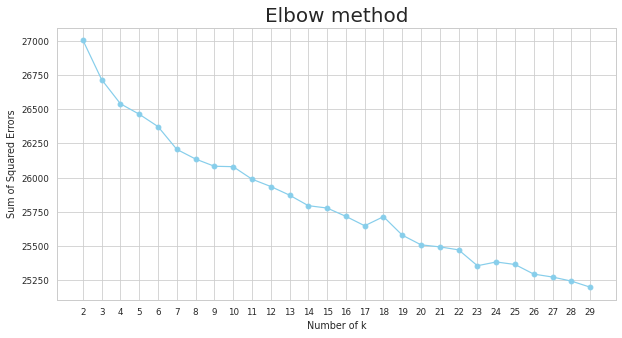

time: 1min 38s (started: 2021-04-11 06:12:17 +00:00)


In [ ]:
# Find optimal k
errors = []
k_range = range(2, 30)
for k in k_range:
    k_means = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=4096,
                              random_state=1).fit(X_pca)
    errors.append(k_means.inertia_)

plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
sns.set_context('paper')
plt.plot(k_range, errors, marker='o', color='skyblue')
plt.xticks(k_range)
plt.xlabel('Number of k')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow method', fontsize=20)

Using the elbow method, we can see in the plot above that the decline of the sum of squared errors (or distortion) becomes considerably less after k=17. Since the turning point is at k = 17, we will use 17 as the number of clusters for the KMeans model below.

In [ ]:
# Using k=20 to construct mini-batch kmeans model
k_means = MiniBatchKMeans(n_clusters=17, init_size=1024, batch_size=4096, random_state=1)
y = k_means.fit_predict(X_tfidf)

time: 2.71 s (started: 2021-04-11 06:15:24 +00:00)


After training the mini-batch KMeans clustering, we can use this model to fit and predict the cluster label for each paper.

## Cluster Evaluation using Classification

With the labels generated by KMeans, we can proceed to use a simple supervised classifier to try evaluating the clustering predictions.

Using train-test-split and an SGD classifier, we can check the appropriateness of the predicted KMeans clusters as valid labels.

In [ ]:
# Fit and predict the clusters using a simple SGD Classifier
X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), y, test_size=0.2, random_state=1)

sgd = SGDClassifier(max_iter=10000, random_state=1, n_jobs=-1).fit(X_train, y_train)

y_train_pred = sgd.predict(X_train)
print(f'Train Accuracy: {accuracy_score(y_train, y_train_pred)}')

y_pred = sgd.predict(X_test)
print(f'Validation Accuracy: {accuracy_score(y_test, y_pred)}')

Train Accuracy: 0.909049491842218
Validation Accuracy: 0.9031509431023472
time: 1min 3s (started: 2021-04-11 06:21:57 +00:00)


In [ ]:
print(classification_report(y_test, y_pred, target_names=["{:02d}".format(x) for x in range(1, 18)]))

              precision    recall  f1-score   support

          01       0.87      0.98      0.92      4282
          02       0.88      0.96      0.92      4676
          03       0.94      0.89      0.92      2570
          04       0.90      0.90      0.90      5428
          05       0.91      0.89      0.90      5178
          06       0.91      0.86      0.88       839
          07       0.94      0.93      0.93      1957
          08       0.95      0.88      0.91      1644
          09       0.87      0.94      0.90     12784
          10       0.94      0.88      0.91      2001
          11       0.92      0.77      0.84      5298
          12       0.91      0.83      0.87      5147
          13       0.92      0.91      0.91      1130
          14       0.92      0.88      0.90      2362
          15       0.92      0.94      0.93      3545
          16       0.93      0.96      0.94      1354
          17       0.92      0.92      0.92      4008

    accuracy              

The calidation accuracy and the classification report show that the cluster labels are fairly accurate for classifying the research papers in our data.

## Cluster Keywords

### Latent Dirichlet Allocation (LDA) Attempt

Topic modeling is a type of unsupervised document classification that uses clustering to group documents based on their topics. As one of the most popular method in topic modeling, LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words while each document is a mixture over a set of topics.

However, LDA model takes up too much time on this large-scale dataset and the resulting topics contain repetitive words that are difficult to interpret. Hence, we will use the KMeans clusters for keyword interpretation.


In [ ]:
# # Attempt to use LDA but takes too long
# def get_top_keywords(model, vectorizer, n_terms):
#     words = vectorizer.get_feature_names()
#     for i, topic in enumerate(model.components_):
#         print('\nTopic {}'.format(i+1))
#         print(" ".join([words[i] for i in topic.argsort()[:-n_terms - 1:-1]]))

# lda = LatentDirichletAllocation(n_components=6, learning_method='online',
#                                 verbose=False, random_state=1).fit(X_tfidf)

# get_top_keywords(lda, tfidf, 10)


Topic 1
patients covid mortality hospital group clinical risk age days treatment

Topic 2
cells protein cell sars cov virus viral proteins expression binding

Topic 3
cov sars pcr samples virus detection viruses rt viral positive

Topic 4
model models method learning proposed time different performance les network

Topic 5
covid health pandemic care social public measures healthcare countries lockdown

Topic 6
covid sars cov disease coronavirus respiratory severe patients infection syndrome
time: 15min 19s (started: 2021-04-10 23:21:59 +00:00)


### K-Means Clustering Keywords

Since the K-Means clusters seem to be reasonably meaningful from the previous classification, we can take a look at the keywords from each cluster in order to gain insights.

In [ ]:
# Using the predicted kmeans clusters (tfidf-supported) to check cluster keywords
def get_top_keywords(data, kmclusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(kmclusters).mean()
    for i, val in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(', '.join([labels[t] for t in np.argsort(val)[-n_terms:]]))

get_top_keywords(X_tfidf, y, tfidf.get_feature_names(), 10)


Cluster 1
acute, virus, severe, syndrome, respiratory, infection, covid, coronavirus, sars, cov

Cluster 2
admission, icu, clinical, risk, severe, disease, hospital, mortality, covid, patients

Cluster 3
cell, cells, host, replication, binding, virus, viral, rna, proteins, protein

Cluster 4
practice, services, patient, medical, health, healthcare, patients, pandemic, covid, care

Cluster 5
spread, model, crisis, distancing, measures, economic, countries, pandemic, covid, social

Cluster 6
impact, india, health, march, measures, air, pandemic, period, covid, lockdown

Cluster 7
resection, performed, technique, operative, complications, postoperative, surgical, patients, laparoscopic, surgery

Cluster 8
covid, protease, activity, inhibitors, cov, sars, antiviral, compounds, drugs, drug

Cluster 9
method, disease, models, analysis, different, new, time, research, data, model

Cluster 10
sensitivity, test, positive, testing, detection, sars, cov, samples, rt, pcr

Cluster 11
trial, strok

# Insights and Guidance based on Model Findings

From 2019 to 2020, there has been an explosive amount of research papers dedicated to the study of Covid-19. In this corpus of research papers, there are several main topics of discussion made obvious throughout the EDA process:
- Transmission pathway studies;
- Virus studies (biological structures);
- Infection severity studies;
- Treatment plan studies;
- Risk factor studies.

With clustering analysis using mainly mini-batch k-means model (k = 17), we were able to identify the main clusters within the corpus of research paper abstracts. The optimal number of clusters was determined through the use of the elbow method in which we modeled the sum of squared errors against a range of k values. Although a model with more clusters (larger k) would lead to the inclusion of more relevant keywords within each cluster, it does result in lower accuracies in both training and test sets when evaluating using an SGD classifier. Nonetheless, since the model does not yet exhibit signs of overfitting or underfitting, the number of clusters can be changed to show more relevant keyword lists.

The following actionable insights and guidance can be derived from the model results (cluster keywords):
- From clusters 1, 2, and 12 we can see that the respiratory infections caused by Covid-19 can be severe and acute, with dire outcomes. All aspects of society should treat this pandemic as it is, and plan accordingly.
- For scientists, keyword results from clusters 3, 9, 14, and 15 indicate the following research focuses:
    - Scientists should continue to work on studying the "binding" mechanisms and the RNA/protein structures of the virus;
    - Patient data should be used to build models in order to discover more about the disease;
    - More resources should be used in studying respiratory pathogens in a cellular level, which could be achieved by conducting more experiments on mice.
- For doctors, nurses, and other healthcare professionals, keyword results from clusters 4, 7, 8, 10, 11, 12, and 17 show the following key points:
    - Extra care should be taken when treating Covid-19 patients, including the use of personal protective equipments;
    - Symptoms and conditions of patients can be severe and acute, especially with older people;
    - Covid-related treatments could be multifaceted, which could include the use of drugs, performing surgeries, post-op care methods, and even psychological treatments (consults regarding stress, anxiety, and depression).
- For governments, industries, and society as a whole, the model results suggest the following:
    - Despite the impact on economy, governments should strictly enforce lockdowns and social distancing, such that people can keep the chance of contracting Covid-19 at a minimum;
    - Industries should continue to use remote-working as an alternative during the pandemic;
    - Industries should try to increase the production of personal protective equipments and vaccines;
    - Governments should increase effective testing (and contact tracing) for Covid-19 patients;
    - Governments and industries should try utilizing some of the resources to support essential service workers, healthcare professionals, and scientific researchers as best as possible;
    - Schools should remain closed and online education should continue until the pandemic has been contained in order to ensure the safety of students;
    - Governments should make plans or policies to better support citizens throughout this challenging time, both financially and psychologically (industries should do the same for their employees).

I sincerely hope that the world can work together to combat this pandemic so that the Covid-19 situation can end soon.